In [14]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
from ultralytics import FastSAM
from scipy import stats
import matplotlib.pyplot as plt
import zxing

def check(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ddepth = cv2.CV_32F 
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    blurred = cv2.blur(gradient, (9, 9))
    _, thresh = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)
    cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return 0
    c = max(cnts, key=cv2.contourArea)
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int32(box) 
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    return 1

def check_qr_code(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    potential_qr = []

    for cnt in contours:
        epsilon = 0.02 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        if len(approx) == 4:
            potential_qr.append(approx)

    if len(potential_qr) >= 3:
        return True

    return False

def extract_segments(image_path):
    output_dir = "./segments"
    os.makedirs(output_dir, exist_ok=True)
    model = FastSAM('FastSAM-s.pt')
    original_image = Image.open(image_path)
    image_np = np.array(original_image)
    image_area = original_image.size[0] * original_image.size[1]
    results = model(original_image, device='cuda' if torch.cuda.is_available() else 'cpu',
                    retina_masks=True, conf=0.4, iou=0.9)
    annotations = results[0].masks.data
    if annotations is None:
        print("No segments detected")
        return []
    segments = []
    for idx, annotation in enumerate(annotations):
        mask = annotation.cpu().numpy()
        mask = cv2.resize(mask, (original_image.size[0], original_image.size[1]))
        mask = mask > 0.5
        segment = np.zeros_like(image_np)
        
        segment[mask] = image_np[mask]
        
        y_indices, x_indices = np.where(mask)
        if len(y_indices) > 0 and len(x_indices) > 0:
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            bbox_area = (x_max - x_min + 1) * (y_max - y_min + 1)
            if bbox_area < 0.05 * image_area or bbox_area > 0.9 * image_area:
                print(f"Skipping segment {idx} due to size constraints")
                continue
    
            cropped_segment = segment[y_min:y_max+1, x_min:x_max+1]
            if(check(cropped_segment)==0 and check_qr_code(cropped_segment)==False):
                print(f"Skipping segment {idx} due to segmenation problem")
                continue

            cv2.imwrite(f"{output_dir}/segment_{idx}.png", cv2.cvtColor(cropped_segment, cv2.COLOR_RGB2BGR))
            segments.append({'index': idx, 'mask': mask, 'cropped_segment': cropped_segment})
    
    return segments

def main():
    image_path = "qr-code.jpg"
    
    try:
        segments = extract_segments(image_path)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


0: 352x640 75 objects, 239.0ms
Speed: 5.0ms preprocess, 239.0ms inference, 270.2ms postprocess per image at shape (1, 3, 352, 640)
Skipping segment 0 due to size constraints
Skipping segment 1 due to size constraints
Skipping segment 2 due to size constraints
Skipping segment 3 due to size constraints
Skipping segment 4 due to size constraints
Skipping segment 5 due to size constraints
Skipping segment 6 due to size constraints
Skipping segment 7 due to size constraints
Skipping segment 8 due to size constraints
Skipping segment 9 due to size constraints
Skipping segment 10 due to size constraints
Skipping segment 11 due to size constraints
Skipping segment 12 due to size constraints
Skipping segment 13 due to size constraints
Skipping segment 14 due to size constraints
Skipping segment 15 due to size constraints
Skipping segment 16 due to size constraints
Skipping segment 17 due to size constraints
Skipping segment 18 due to size constraints
Skipping segment 19 due to size constraint

Checking if diagonal decoding works

Detected angle: 269.0
Mean of angles is:  89.0


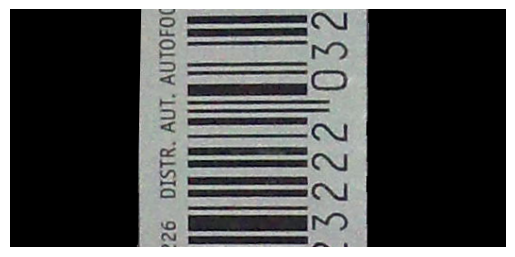

Type: EAN_13
Data: 8023222032262


In [15]:
def check_horizontal(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            # cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            # plt.plot((x1, x2), (y1, y2), 'r')
        angles = [np.degrees(theta) for rho, theta in lines[:, 0]]
        
        if(abs(np.mean(angles)) < 5):
            angle = np.mean(angles)
        else:
            angle = np.mean(angles) + 180  
        print(f"Detected angle: {angle}")
        
        print("Mean of angles is: ", np.mean(angles))
        if(np.mean(angles) < 90):
            angle = angle + 180

        (h, w) = img.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_img = cv2.warpAffine(img, M, (w, h))
    else:
        print("No rotation detected")
        rotated_img = img  

    plt.figure()
    plt.imshow(rotated_img)
    plt.axis("off")
    plt.show()

    return rotated_img

image_path = "segments/segment_0.png"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rotated_img = check_horizontal(img)

os.makedirs("rotated_segments", exist_ok=True)
cv2.imwrite("rotated_segments/rotated_segment.png", cv2.cvtColor(rotated_img, cv2.COLOR_RGB2BGR))

rotated_path = "segments/segment_0.png"
reader = zxing.BarCodeReader()
barcode1 = reader.decode(rotated_path)
if barcode1:
    print("Type:", barcode1.format)
    print("Data:", barcode1.raw)
else:
    print("No barcode detected.")

In [17]:
import cv2
from pyzbar import pyzbar
from PIL import Image
import numpy as np

def decode_qr_code_with_zbar(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return "Could not load image."
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pil_image = Image.fromarray(gray)
    scanner = zbar.Scanner()
    results = scanner.scan(pil_image)
    if not results:
        return "No code detected."
    
    decoded_data = []
    for result in results:
        code_data = result.data.decode('utf-8')
        code_type = result.type
        decoded_data.append({
            'type': code_type,
            'data': code_data
        })
        print(f"Type: {code_type}")
        print(f"Data: {code_data}")
        if hasattr(result, 'position'):
            points = result.position
            for i in range(len(points)):
                cv2.line(image, 
                        tuple(points[i]), 
                        tuple(points[(i + 1) % len(points)]), 
                        (0, 255, 0), 3)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Code Detection")
    plt.axis('off')
    plt.show()
    
    return decoded_data

# Test the function
image_path = "../segments/segment_53.png"
result = decode_qr_code_with_zbar(image_path)
print("\nDecoded Results:")
for item in result:
    print(f"Type: {item['type']}, Data: {item['data']}")


Decoded Results:


[ WARN:0@11674.688] global loadsave.cpp:241 findDecoder imread_('../segments/segment_53.png'): can't open/read file: check file path/integrity


TypeError: string indices must be integers, not 'str'